<a href="https://colab.research.google.com/github/sowmyakavali/ML-Practice/blob/main/Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Augmentation For Objectdetection**

#### **Install albumentation library**

In [ ]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

albumentations==1.1.0 is successfully installed


#### **Import Libraries**

In [ ]:
%matplotlib inline
import os
import cv2
import time
import random
import argparse
import numpy as np
import glob as glob
from tqdm import tqdm
import albumentations as A
from matplotlib import pyplot as plt

#### **Convert labels from yolo format to pascal voc format**

In [ ]:
#convert from Yolo_mark to opencv format
def yoloFormattocv(x1, y1, x2, y2, H, W):
    bbox_width = x2 * W
    bbox_height = y2 * H
    center_x = x1 * W
    center_y = y1 * H
    voc = []
    voc.append(center_x - (bbox_width / 2))
    voc.append(center_y - (bbox_height / 2))
    voc.append(center_x + (bbox_width / 2))
    voc.append(center_y + (bbox_height / 2))
    return [int(v) for v in voc]

#### **Function to visualize the annotations**

In [ ]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=3):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox[:4]
    x_min, x_max, y_min, y_max = int(x_min), int( w), int(y_min), int(h)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    # class_name = category_id_to_name[bbox[-1]]
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.85, 5)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
                  img,
                  text=class_name,
                  org=(x_min, y_min - int(0.3 * text_height)),
                  fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                  fontScale=0.85, 
                  color=TEXT_COLOR, 
                  lineType=cv2.LINE_AA,
                )
    return img

def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

#### **Display function**

In [ ]:
def display(images_path, labels_path, category_id_to_name ):
  for img in tqdm(glob.glob(images_path+"/*.jpg")[:10]):
    image = cv2.imread(img)
    H,W = image.shape[:2]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    label_file = img.split("/")[-1].split(".")[0]+".txt"
    bboxes = []
    category_ids = []
    if os.path.isfile(os.path.join(labels_path, label_file)):
       with open(os.path.join(labels_path, label_file), 'r') as f:
            for line in f:
              bbox = line.strip('\n').split(' ')
              box = yoloFormattocv(float(bbox[1]), float(bbox[2]), float(bbox[3]), float(bbox[4]), H, W)
              bboxes.append(box)
              category_ids.append(int(bbox[0]))                 
    visualize(image, bboxes, category_ids, category_id_to_name)  

#### **Paths**

In [ ]:
images_path = "/content/Data/images"
labels_path = "/content/Data/labels"

#### **Display**

100%|██████████| 5/5 [00:00<00:00, 22.37it/s]


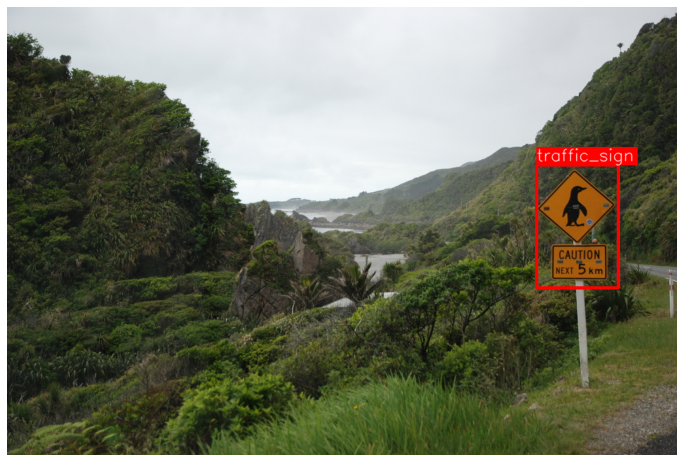

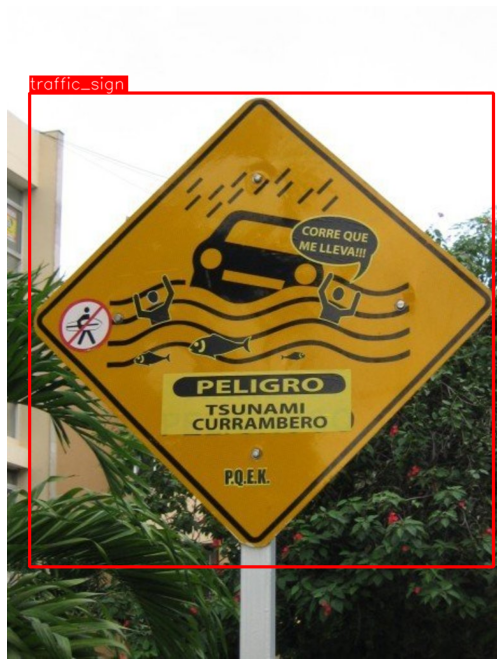

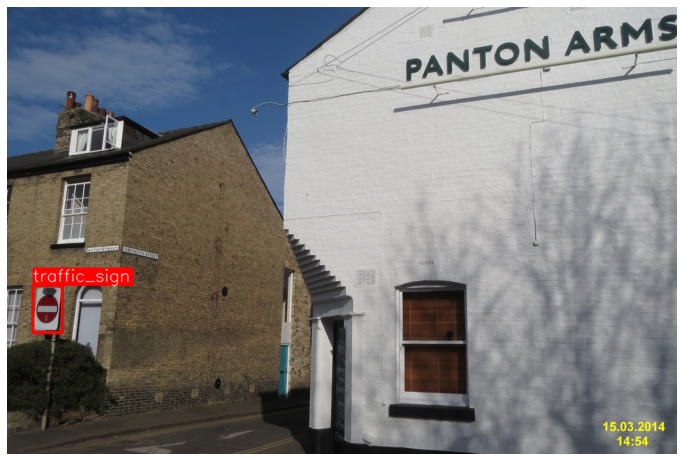

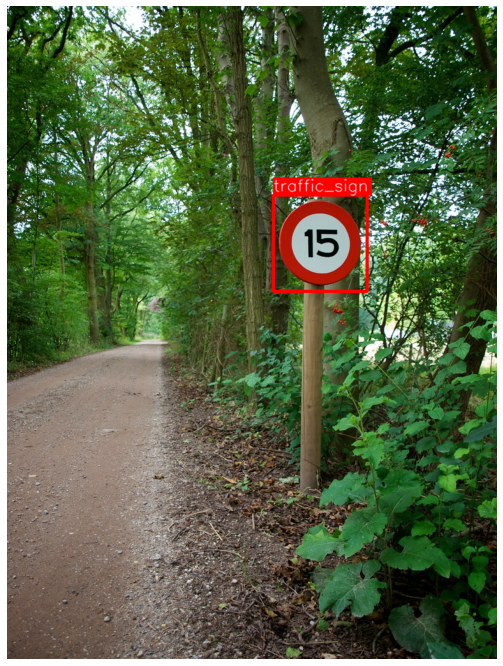

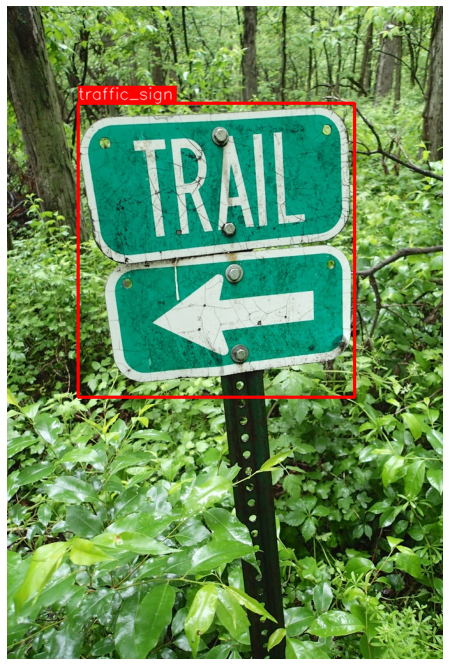

In [ ]:
# We will use the mapping from category_id to the class name
# to visualize the class label for the bounding box on the image
category_id_to_name = { 0: 'traffic_sign'}
display(images_path, labels_path, category_id_to_name )         

#### **Create directories to save results**

In [ ]:
augment_images = os.path.join("content", "data", "images")
augment_labels = os.path.join("content","data", "labels")
if not os.path.exists(augment_images):
   os.makedirs(augment_images)  
if not os.path.exists(augment_labels):
   os.makedirs(augment_labels) 

#### **Apply augmentation methods**

In [ ]:
for img in tqdm(glob.glob(images_path+"/*.jpg")):

        image = cv2.imread(img)
        H,W = image.shape[:2]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image_name = img.split("/")[-1].split(".")[0]
        label_file = image_name + ".txt"

        bboxes = []
        category_ids = []

        if os.path.isfile(os.path.join(labels_path, label_file)):
          with open(os.path.join(labels_path, label_file), 'r') as f:
                for line in f:
                  bbox = line.strip('\n').split(' ')
                  box= list(map(float, bbox[1:]))
                  bboxes.append(box)
                  category_ids.append(int(bbox[0]))

        transform = A.Compose(
                        [A.ToGray(p=0.01),
                         A.MedianBlur(p=0.1),
                         A.RandomBrightnessContrast(p=0.2),
                         A.RandomSizedBBoxSafeCrop(width=512, height=512, erosion_rate=0.2),
                        ],
                        bbox_params=A.BboxParams(format="yolo", min_area=4500, min_visibility=0.3, label_fields=['class_labels']), )
        transformed = transform(image=image, bboxes=bboxes, class_labels=category_ids)  
        image, boxes, labelss = transformed['image'], transformed['bboxes'], transformed['class_labels']   

        image_write_path = os.path.join(augment_images, image_name +'_' + 'aug' + '.jpg')
        label_write_path = os.path.join(augment_labels, image_name +'_' + 'aug' + '.txt')

        if os.path.exists(image_write_path):
            os.remove(image_write_path)  
        if os.path.exists(label_write_path):
            os.remove(label_write_path)     

        cv2.imwrite(image_write_path, image)
        
        mode = 'a' if os.path.exists(label_write_path) else 'w'

        for i,j in zip(boxes,labelss):
            line = [j]
            line.extend(i)
            with open(label_write_path, mode) as fout:   
                new_line =' '.join(map(str, line))                
                fout.write(new_line+'\n') 

100%|██████████| 5/5 [00:00<00:00, 39.64it/s]


#### **Check the results**

100%|██████████| 5/5 [00:00<00:00, 36.29it/s]


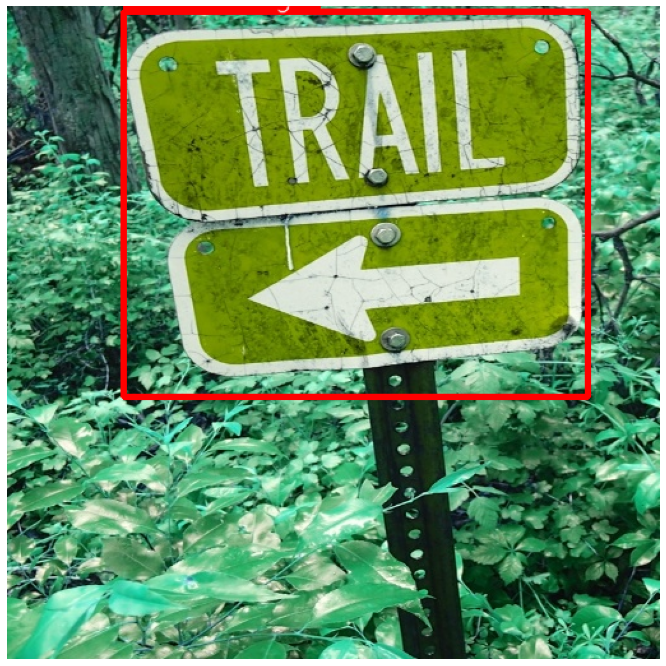

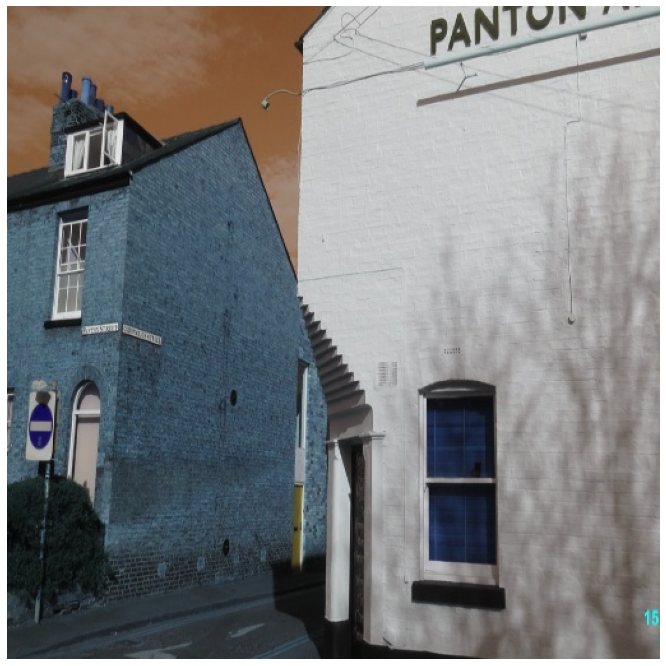

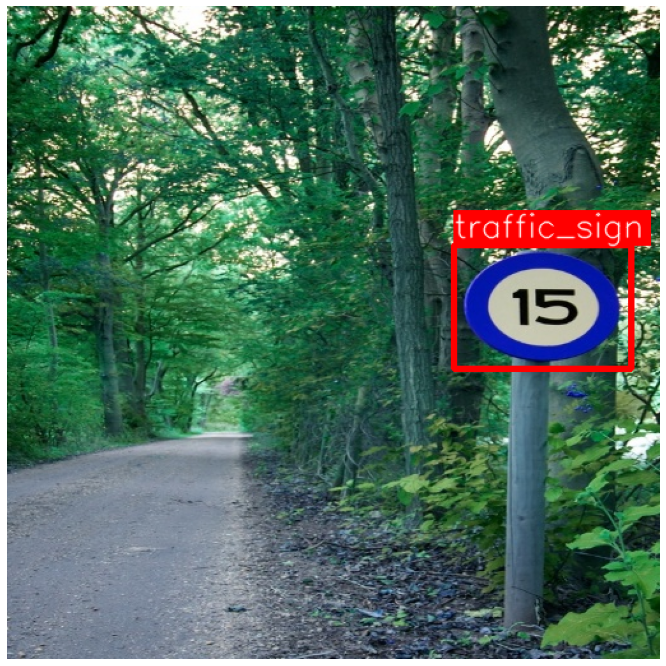

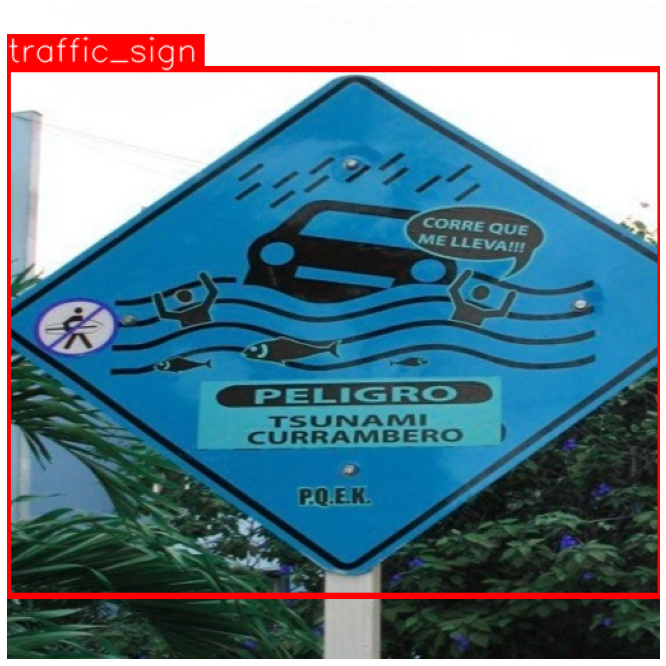

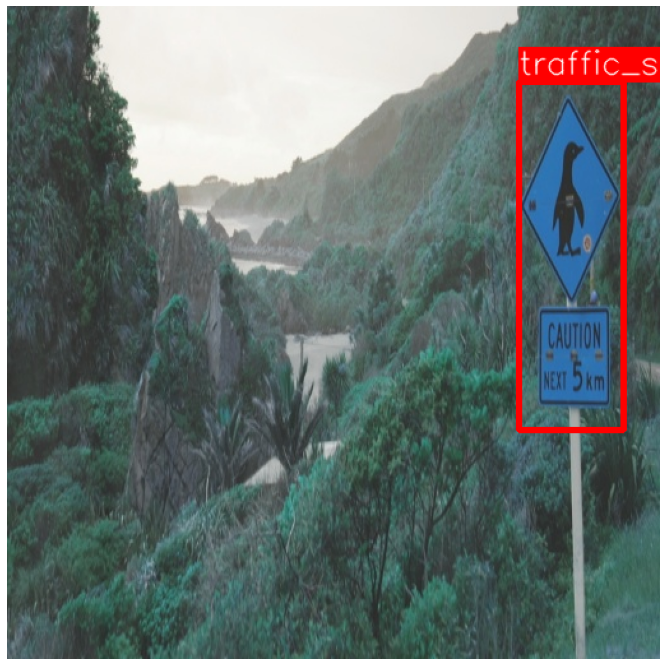

In [ ]:
category_id_to_name = { 0: 'traffic_sign'}
display(augment_images, augment_labels, category_id_to_name )  